In [18]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np

def load_depth_csv(path: Path, depth_scale: float = 0.001) -> np.ndarray:
    """
    CSV形式の深度画像を読み込み，メートル[m]単位に変換して返す関数

    Parameters
    ----------
    path : Path
        深度CSVファイルへのパス
    depth_scale : float
        元の値に掛けるスケール係数
        例）RealSenseのuint16[mm]なら 0.001 を掛けて[m]にする

    Returns
    -------
    depth_m : np.ndarray
        深度[m]（0以下はNaNで無効扱い）
    """
    # CSVを読み込み（float32に変換）
    d = np.loadtxt(path, delimiter=",").astype(np.float32)
    # 0以下の値は無効値としてNaNにしてお
    d[d <= 0] = np.nan
    # スケールを掛けて[m]に変換
    return d * depth_scale

def depth_to_colormap(depth_m: np.ndarray, near: float | None = None, far: float | None = None):
    """
    深度[m]画像をヒートマップ（BGRカラー）に変換する関数

    Parameters
    ----------
    depth_m : np.ndarray
        深度[m]（NaNは無効値）
    near : float | None
        カラーマップに使う手前側の距離[m]
        Noneなら有効画素の5パーセンタイルから自動推定
    far : float | None
        カラーマップに使う奥側の距離[m]
        Noneなら有効画素の95パーセンタイルから自動推定

    Returns
    -------
    depth_cmap : np.ndarray
        COLORMAP_JETでカラー化したBGR画像
    near : float
        実際に使用したnear値
    far : float
        実際に使用したfar値
    """

    # 有効な深度値（NaN以外）だけ取得
    valid = depth_m[np.isfinite(depth_m)]

    # near / far が指定されていない場合は自動推定
    if near is None or far is None:
        if valid.size == 0:
            # すべて無効値だった場合のデフォルトレンジ
            near, far = 0.2, 1.0
        else:
            # 5〜95パーセンタイルをレンジにする
            near = float(np.percentile(valid, 5))
            far  = float(np.percentile(valid, 95))
            # near = far になってしまう場合の対策
            if near == far:
                near, far = max(near - 0.05, 0.05), near + 0.05
    
    # 深度を [0,1] に正規化した後，[0,255] のuint8にスケーリング
    x = np.clip((depth_m - near) / (far - near), 0, 1)
    vis = (x * 255).astype(np.uint8)

    # OpenCVのカラーマップでヒートマップ化（BGR）
    depth_cmap = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
    return depth_cmap, near, far

def show_overlay_inline(
    rgb_path: Path,
    depth_csv_path: Path,
    alpha: float = 0.4,
    near: float | None = None,
    far: float | None = None,
    depth_scale: float = 0.001,
    save_dir: Path | None = None,
):
    """
    RGB画像と深度CSVを読み込み，ヒートマップとオーバーレイを
    Jupyter / Pythonスクリプト上で並べて表示する関数

    Parameters
    ----------
    rgb_path : Path
        RGB画像（BGRとして読み込む）のパス
    depth_csv_path : Path
        深度CSVファイルのパス
    alpha : float
        オーバーレイ時の深度ヒートマップの透過率（0〜1）
    near, far : float | None
        深度レンジ[m]。Noneなら自動推定
    depth_scale : float
        CSVの値 → [m] へのスケール係数
    save_dir : Path | None
        画像保存先ディレクトリ（Noneなら保存しない）

    Returns
    -------
    overlay : np.ndarray
        BGRのオーバーレイ画像
    depth_cmap : np.ndarray
        深度ヒートマップ（BGR）
    near_used : float
        使用したnear値
    far_used : float
        使用したfar値
    saved : dict
        保存したパス（"overlay", "panel", "depth_colormap"）を格納
    """

    # --- RGB画像読み込み（BGRとしてロード） ---
    color = cv2.imread(str(rgb_path))
    if color is None:
        raise FileNotFoundError(f"Could not read RGB image: {rgb_path}")

    # --- 深度CSV読み込み＆[m]変換 ---
    depth_m = load_depth_csv(depth_csv_path, depth_scale=depth_scale)

    # --- 解像度チェック（RGBと深度のサイズが一致しているか） ---
    if (color.shape[0], color.shape[1]) != depth_m.shape:
        raise ValueError(f"Size mismatch: RGB {color.shape[:2]} vs Depth {depth_m.shape}")

    # --- 深度をヒートマップ化 ---
    depth_cmap, near_used, far_used = depth_to_colormap(depth_m, near, far)

    # --- RGBと深度ヒートマップをαブレンド ---
    overlay = cv2.addWeighted(color, 1 - alpha, depth_cmap, alpha, 0)

    # ===== 可視化（matplotlibで並べて表示） =====
    # OpenCV(BGR) → matplotlib(RGB) へ変換
    color_rgb = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    depth_rgb = cv2.cvtColor(depth_cmap, cv2.COLOR_BGR2RGB)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15,5))
    # 左：RGB
    plt.subplot(1,3,1); plt.imshow(color_rgb); plt.title("RGB"); plt.axis("off")
    # 中央：深度ヒートマップ（near / far をタイトルに表示）
    plt.subplot(1,3,2); plt.imshow(depth_rgb); plt.title("Depth"); plt.axis("off")
     # 右：オーバーレイ
    plt.subplot(1,3,3); plt.imshow(overlay_rgb); plt.title("Overlay"); plt.axis("off")
    plt.show()

    # ===== 保存処理 =====
    saved = {}
    if save_dir is not None:
        save_dir = Path(save_dir)
        (save_dir / "overlay").mkdir(parents=True, exist_ok=True)
        (save_dir / "panel").mkdir(parents=True, exist_ok=True)
        (save_dir / "depth_colormap").mkdir(parents=True, exist_ok=True)  
        stem = rgb_path.stem
        overlay_path = save_dir / "overlay" / f"{stem}.png"
        panel_path = save_dir / "panel" / f"{stem}_panel.png"
        depth_path = save_dir / "depth_colormap" / f"{stem}_depth.png"    
        
        cv2.imwrite(str(overlay_path), overlay)
        cv2.imwrite(str(depth_path), depth_cmap)                         
        panel_img = np.hstack([color, depth_cmap, overlay])
        cv2.imwrite(str(panel_path), panel_img)
        saved["overlay"] = str(overlay_path)
        saved["panel"] = str(panel_path)
        saved["depth_colormap"] = str(depth_path)                        

    return overlay, depth_cmap, near_used, far_used, saved



In [19]:
print(Path("./data/rgb/2025-01-20T16-56-09.png").exists())

True


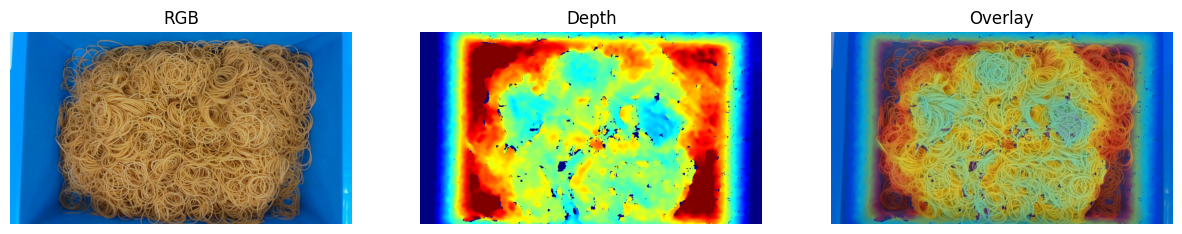

In [20]:
overlay, depth_cmap, near_used, far_used, saved = show_overlay_inline(
    rgb_path=Path("./data/rgb/2025-01-20T16-56-09.png"),
    depth_csv_path=Path("./data/csv_depth/2025-01-20T16-56-09.csv"),
    alpha=0.4,          # 重ね具合
    near=None, far=None,# 自動推定。固定したければmで指定
    depth_scale=0.001,  # RealSense: uint16 -> m
    save_dir=None
    #save_dir=Path("./data")  # 保存したくなければ None
)

#print("near/far used:", near_used, far_used)
#print(saved)

True True


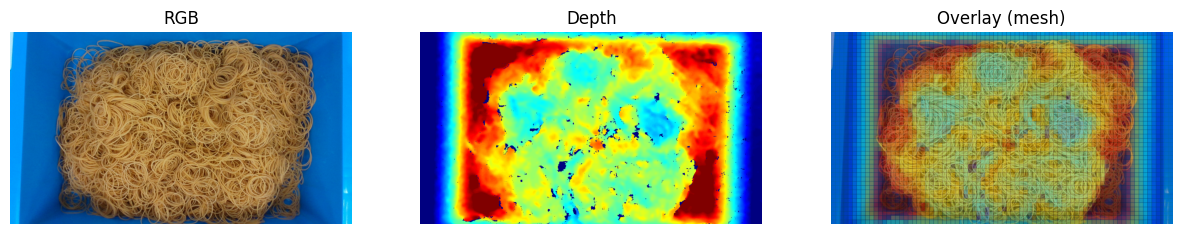

In [21]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np


def load_depth_csv(path: Path, depth_scale: float = 0.001) -> np.ndarray:
    """
    CSV形式の深度画像を読み込み，[m]単位に変換して返す。

    depth_scale:
        RealSense の uint16[mm] → [m] なら 0.001
    """
    d = np.loadtxt(path, delimiter=",").astype(np.float32)
    d[d <= 0] = np.nan  # 0以下は無効値として NaN
    return d * depth_scale


def depth_to_colormap(
    depth_m: np.ndarray,
    near: float | None = None,
    far: float | None = None,
):
    """
    深度[m]画像を JET カラーマップの BGR 画像に変換する。

    near / far が None の場合は有効画素の 5〜95 パーセンタイルから自動推定。
    """
    valid = depth_m[np.isfinite(depth_m)]

    if near is None or far is None:
        if valid.size == 0:
            near, far = 0.2, 1.0
        else:
            near = float(np.percentile(valid, 5))
            far = float(np.percentile(valid, 95))
            if near == far:
                near, far = max(near - 0.05, 0.05), near + 0.05

    x = np.clip((depth_m - near) / (far - near), 0, 1)
    vis = (x * 255).astype(np.uint8)

    depth_cmap = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
    return depth_cmap, near, far


def to_mesh_style(
    depth_cmap: np.ndarray,
    cell: int = 16,
    line_thickness: int = 1,
) -> np.ndarray:
    """
    深度ヒートマップを「メッシュ調」に見えるように加工する。

    - cell: 1マスのサイズ（大きいほど荒いメッシュ）
    - line_thickness: 格子線の太さ（0 なら線なしでブロック状だけ）
    """
    h, w = depth_cmap.shape[:2]

    # ① 粗いグリッドにリサイズしてブロック状に
    small_w = max(1, w // cell)
    small_h = max(1, h // cell)

    small = cv2.resize(depth_cmap, (small_w, small_h), interpolation=cv2.INTER_AREA)
    blocky = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)

    # ② 格子線を描画
    mesh = blocky.copy()
    line_color = (0, 0, 0)  # 黒線

    if line_thickness > 0:
        # 横線
        for y in range(0, h, cell):
            cv2.line(mesh, (0, y), (w, y), line_color, thickness=line_thickness)
        # 縦線
        for x in range(0, w, cell):
            cv2.line(mesh, (x, 0), (x, h), line_color, thickness=line_thickness)

    return mesh


def show_overlay_inline(
    rgb_path: Path,
    depth_csv_path: Path,
    alpha: float = 0.4,
    near: float | None = None,
    far: float | None = None,
    depth_scale: float = 0.001,
    save_dir: Path | None = None,
    use_mesh: bool = True,
    mesh_cell: int = 16,
    mesh_line_thickness: int = 1,
):
    """
    RGB ＋ 深度CSV を読み込み，ヒートマップとオーバーレイを表示＆保存する。

    use_mesh=True のとき，Overlay はメッシュ調ヒートマップを使用。
    真ん中の Depth パネルは従来通りのベタ塗りヒートマップ。
    """
    # --- RGB 読み込み（BGR） ---
    color = cv2.imread(str(rgb_path))
    if color is None:
        raise FileNotFoundError(f"Could not read RGB image: {rgb_path}")

    # --- 深度読み込み ---
    depth_m = load_depth_csv(depth_csv_path, depth_scale=depth_scale)

    if (color.shape[0], color.shape[1]) != depth_m.shape:
        raise ValueError(f"Size mismatch: RGB {color.shape[:2]} vs Depth {depth_m.shape}")

    # --- 深度 → ヒートマップ ---
    depth_cmap, near_used, far_used = depth_to_colormap(depth_m, near, far)

    # --- オーバーレイ用のヒートマップ（メッシュ or 通常） ---
    if use_mesh:
        depth_cmap_for_overlay = to_mesh_style(
            depth_cmap,
            cell=mesh_cell,
            line_thickness=mesh_line_thickness,
        )
    else:
        depth_cmap_for_overlay = depth_cmap

    # --- αブレンド ---
    overlay = cv2.addWeighted(color, 1 - alpha, depth_cmap_for_overlay, alpha, 0)

    # ===== matplotlib で並べて表示（RGB 変換） =====
    color_rgb = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    depth_rgb = cv2.cvtColor(depth_cmap, cv2.COLOR_BGR2RGB)  # 中央パネルは通常ヒートマップ
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(color_rgb)
    plt.title("RGB")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depth_rgb)
    plt.title("Depth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_rgb)
    plt.title("Overlay (mesh)" if use_mesh else "Overlay")
    plt.axis("off")

    plt.show()

    # ===== 画像保存 =====
    saved: dict[str, str] = {}
    if save_dir is not None:
        save_dir = Path(save_dir)

        (save_dir / "overlay").mkdir(parents=True, exist_ok=True)
        (save_dir / "panel").mkdir(parents=True, exist_ok=True)
        (save_dir / "depth_colormap").mkdir(parents=True, exist_ok=True)

        stem = rgb_path.stem
        overlay_path = save_dir / "overlay" / f"{stem}.png"
        panel_path = save_dir / "panel" / f"{stem}_panel.png"
        depth_path = save_dir / "depth_colormap" / f"{stem}_depth.png"

        cv2.imwrite(str(overlay_path), overlay)
        cv2.imwrite(str(depth_path), depth_cmap)  # 保存は通常のヒートマップ

        panel_img = np.hstack([color, depth_cmap, overlay])
        cv2.imwrite(str(panel_path), panel_img)

        saved["overlay"] = str(overlay_path)
        saved["panel"] = str(panel_path)
        saved["depth_colormap"] = str(depth_path)

    return overlay, depth_cmap, near_used, far_used, saved


# ===== 動作確認用サンプル =====
if __name__ == "__main__":
    rgb_path = Path("./data/rgb/2025-01-20T16-56-09.png")
    depth_path = Path("./data/csv_depth/2025-01-20T16-56-09.csv")

    print(rgb_path.exists(), depth_path.exists())

    overlay, depth_cmap, near_used, far_used, saved = show_overlay_inline(
        rgb_path=rgb_path,
        depth_csv_path=depth_path,
        alpha=0.4,
        near=None,
        far=None,
        depth_scale=0.001,
        #save_dir=Path("./data/"),
        use_mesh=True,          # ★ メッシュ調オーバーレイ
        mesh_cell=16,
        mesh_line_thickness=1,
    )

    #print("near/far used:", near_used, far_used)
    #print(saved)